# MatchOptimizer bug
MatchOptimizer produces a matched dataframe with more treatment/control matches than in the source dataframe.


In [1]:
# Note: Some of the content in this notebook is derived from work done by Mike Yung

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.propensity import ElasticNetPropensityModel
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


## Synthetic Data Generation

In [4]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [5]:
y # outcome variable
# X # independent variables
# treatment # w, treatment flag
# tau # individual treatment effect
# b # expected outcome
# e # treatment propensity

array([2.09553956, 2.99234788, 2.0689079 , ..., 2.04699878, 3.07997556,
       2.4361889 ])

# Create base DF

In [6]:
TREATMENT_COL = 'W'
PROPENSITY_COL = 'pihat'
OUTCOME_COL = 'y'

In [7]:
df = pd.DataFrame(X)
df = df.add_prefix("X")
df[TREATMENT_COL] = treatment
df[PROPENSITY_COL] = e
df

,X0,X1,X2,X3,X4,X5,X6,X7,W,pihat
0,0.492231,0.385142,0.872106,0.363288,0.743950,0.429233,0.665893,0.048766,0,0.560989
1,0.330137,0.987845,0.619175,0.402743,0.876637,0.386752,0.874801,0.528981,1,0.854481
2,0.898132,0.808227,0.195526,0.803269,0.210270,0.859991,0.899106,0.257176,1,0.758578
3,0.452949,0.940397,0.062331,0.749200,0.771855,0.667109,0.570781,0.605579,1,0.900000
4,0.524973,0.843261,0.057313,0.229413,0.135677,0.394654,0.536435,0.075396,1,0.900000
...,...,...,...,...,...,...,...,...,...,...
9995,0.138606,0.505599,0.669075,0.451669,0.058391,0.692365,0.333172,0.010052,0,0.218385
9996,0.119110,0.665001,0.878683,0.505314,0.567432,0.935550,0.215294,0.031734,0,0.246280
9997,0.522840,0.463454,0.862620,0.448679,0.262980,0.573547,0.871171,0.772075,1,0.689824
9998,0.631689,0.572063,0.324459,0.101342,0.541866,0.629863,0.712246,0.431014,1,0.900000


# Display balance pre/post weighting by inverse probability of treatment (IPTW)

In [8]:
from causalml.metrics.visualize import *

In [9]:
covariates = [col for col in df if col.startswith('X')]
covariates

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

The `plot_ps_diagnostics` function illustrates pre/post weighting by inverse probability of treatment.

In [10]:
create_table_one(data=df, treatment_col=TREATMENT_COL, features=covariates)

,Control,Treatment,SMD
Variable,,,
n,4776,5224,
X0,0.39 (0.29),0.60 (0.25),0.7756
X1,0.39 (0.29),0.60 (0.25),0.7656
X2,0.50 (0.29),0.50 (0.29),0.0138
X3,0.50 (0.29),0.50 (0.29),0.0002
X4,0.49 (0.29),0.50 (0.29),0.0384
X5,0.50 (0.29),0.50 (0.29),-0.0101
X6,0.50 (0.29),0.51 (0.29),0.009
X7,0.50 (0.29),0.50 (0.29),-0.0026


We can see that for this synthetic data, the X0 and X1 variables are obviously not balanced.  We can also verify this by looking at the histograms.

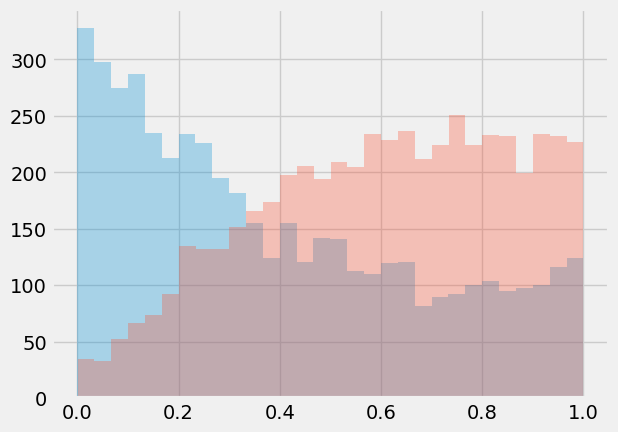

In [11]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X0'], alpha=0.3, bins=30))

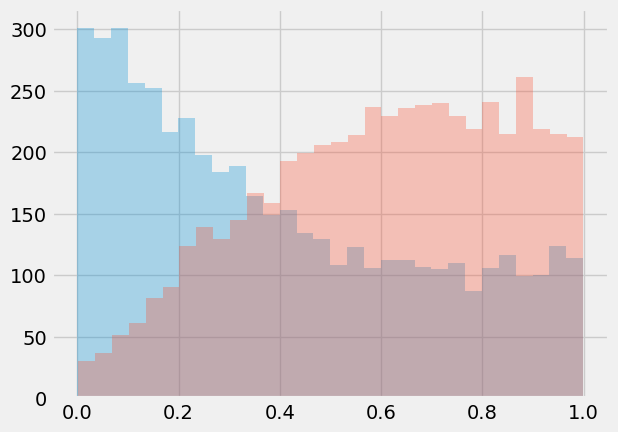

In [12]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X1'], alpha=0.3, bins=30))

From `plot_ps_diagnostics`, `create_table_one`, and via the above histograms, we see that X0 and X1 are clearly unbalanced.

Note that `plot_ps_diagnostics` function shows that we can improve balance through IPTW.  However, we will illustrate below how using matching can also improve balance independent of IPTW.

# Matching

Now let's apply matching to see if we can reduce the SMDs.

The `NearestNeighborMatch` class expects a Pandas DataFrame when `match()` is called, so first we package the existing features data `X` into a dataframe. 

Next, we instantiate `NearestNeighborMatch` and define `score_cols` to specify the matcher to match on just the propensity variable.

In [13]:
matcher = NearestNeighborMatch()
score_cols = [PROPENSITY_COL]
df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)
create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates)

,Control,Treatment,SMD
Variable,,,
n,2209,2209,
X0,0.49 (0.27),0.50 (0.28),0.0348
X1,0.50 (0.27),0.50 (0.27),-0.0109
X2,0.50 (0.29),0.50 (0.29),0.0057
X3,0.51 (0.29),0.50 (0.29),-0.0137
X4,0.50 (0.29),0.51 (0.29),0.022
X5,0.51 (0.30),0.50 (0.29),-0.0086
X6,0.50 (0.29),0.50 (0.29),-0.0019
X7,0.50 (0.29),0.51 (0.29),0.0195


`df_matched` contains the matched subset:

In [14]:
df_matched.shape

(4418, 10)

SMD is the standardized mean difference of the variable between the two classes (Control and Treatment). An SMD value of < 0.1 is typically considered a good balance. Using the synthetically generated data, we achieve good balance for all covariates when matching on the propensity score alone. However, sometimes you may find that matching purely on the propensity variable does not achieve good balance for all the covariates you would like to control for.

### 4b. Match Optimization

In [15]:
df['noise'] = df.apply(lambda x: np.random.randn()-0.3 if x[TREATMENT_COL]==1 else np.random.randn(), axis=1)

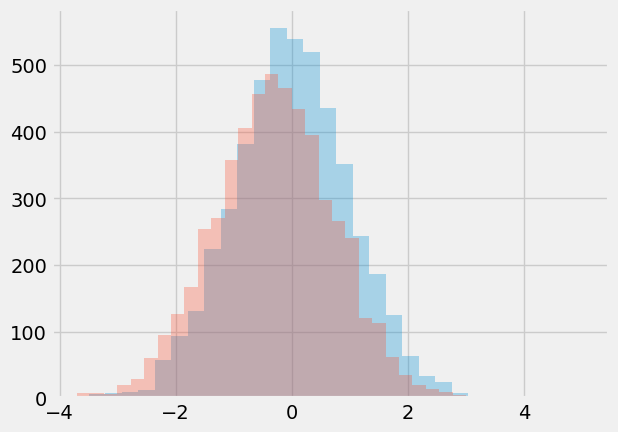

In [16]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['noise'], alpha=0.3, bins=30))

Let's redo the propensity scoring + matching process and take a look at the results.

In [17]:
p_model = ElasticNetPropensityModel()
p_hat = p_model.fit_predict(X=np.hstack((X, df['noise'].values.reshape(-1,1))),
                            y=treatment)

df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)

# define your own covariates to check matched balance
covariates_to_check = [col for col in df_matched if col != TREATMENT_COL and col != OUTCOME_COL]

create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,2211,2211,
X0,0.49 (0.27),0.50 (0.28),0.0396
X1,0.50 (0.27),0.50 (0.27),-0.0034
X2,0.50 (0.29),0.51 (0.29),0.0071
X3,0.51 (0.29),0.50 (0.29),-0.0297
X4,0.50 (0.29),0.50 (0.29),0.0185
X5,0.51 (0.30),0.50 (0.29),-0.0151
X6,0.50 (0.29),0.51 (0.29),0.0321
X7,0.50 (0.29),0.50 (0.29),-0.0079


Now, the noise variable (which inherently has an imbalanced distribution between classes) does not achieve an acceptable SMD score. `causalml` has a built-in `MatchOptimizer` that will search for the best combinations of parameters to achieve good balance across all variables (refer to docs for more detail).

In [18]:
if 'noise' not in covariates_to_check:
    covariates_to_check.append('noise')

opt = MatchOptimizer(treatment_col=TREATMENT_COL,
                     ps_col=PROPENSITY_COL,
                     matching_covariates=covariates_to_check,
                     caliper_range=(0.01,1))
df_matched = opt.search_best_match(df)

In [19]:
create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,5224,5224,
X0,0.59 (0.24),0.60 (0.25),0.0441
X1,0.60 (0.25),0.60 (0.25),-0.0046
X2,0.51 (0.28),0.50 (0.29),-0.0393
X3,0.50 (0.29),0.50 (0.29),0.0288
X4,0.49 (0.29),0.50 (0.29),0.0475
X5,0.51 (0.30),0.50 (0.29),-0.0284
X6,0.51 (0.28),0.51 (0.29),-0.0007
X7,0.50 (0.29),0.50 (0.29),-0.0095


In [20]:
df_matched.shape

(10448, 11)

In [21]:
df.shape

(10000, 11)

In [22]:
df_matched.shape[0]<=df.shape[0]

False

In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.propensity import ElasticNetPropensityModel
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *


In [24]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [25]:
TREATMENT_COL = 'W'
PROPENSITY_COL = 'pihat'
OUTCOME_COL = 'y'

In [26]:
df = pd.DataFrame(X)
df = df.add_prefix("X")
df[TREATMENT_COL] = treatment
df[PROPENSITY_COL] = e

In [27]:
covariates = [col for col in df if col.startswith('X')]

In [28]:
matcher = NearestNeighborMatch()
score_cols = [PROPENSITY_COL]
df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)
#create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates)

In [29]:
df['noise'] = df.apply(lambda x: np.random.randn()-0.3 if x[TREATMENT_COL]==1 else np.random.randn(), axis=1)

In [30]:
p_model = ElasticNetPropensityModel()
p_hat = p_model.fit_predict(X=np.hstack((X, df['noise'].values.reshape(-1,1))),
                            y=treatment)

df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)


In [31]:
covariates_to_check = [col for col in df_matched if col != TREATMENT_COL and col != OUTCOME_COL]


In [32]:
if 'noise' not in covariates_to_check:
    covariates_to_check.append('noise')

opt = MatchOptimizer(treatment_col=TREATMENT_COL,
                     ps_col=PROPENSITY_COL,
                     matching_covariates=covariates_to_check,
                     caliper_range=(0.01,1))
df_matched = opt.search_best_match(df)

In [33]:
df_matched.shape[0]<=df.shape[0]

False